<ipython-input-3-98685af81e08>:16: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("/content/preprocessed_train_data (1).csv")
<ipython-input-3-98685af81e08>:31: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df[target_col].fillna(train_df[target_col].mode()[0], inplace=True)
<ipython-input-3-98685af81e08>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu


Classification Report:
              precision    recall  f1-score   support

           1       0.99      0.99      0.99     38076
           2       0.99      0.99      0.99     30910
           3       0.63      0.61      0.62      5523
           4       0.99      0.99      0.99     34420
           5       0.68      0.70      0.69      6704
           6       1.00      0.99      0.99     33656

    accuracy                           0.97    149289
   macro avg       0.88      0.88      0.88    149289
weighted avg       0.97      0.97      0.97    149289


Confusion Matrix:


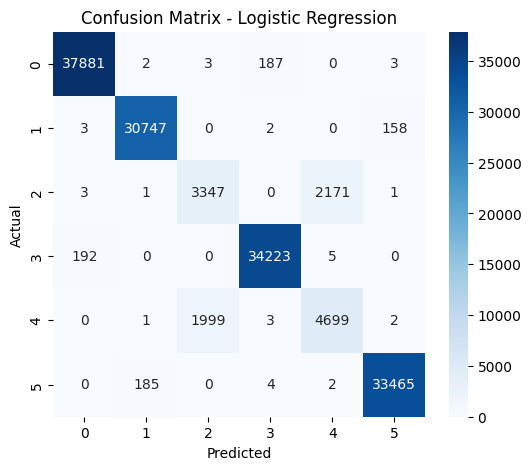

Predictions saved to 'predicted_clusters.csv'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:

# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# For file download (only in Colab)
from google.colab import files

# Step 2: Load Datasets
train_df = pd.read_csv("/content/preprocessed_train_data (1).csv")
test_df = pd.read_csv("/content/preprocessed_test_data (1).csv")

# Step 3: Encode 'outlet_city' Safely
combined_cities = pd.concat([train_df["outlet_city"], test_df["outlet_city"]], axis=0).astype(str)
city_encoder = LabelEncoder()
city_encoder.fit(combined_cities)

train_df["outlet_city"] = city_encoder.transform(train_df["outlet_city"].astype(str))
test_df["outlet_city"] = city_encoder.transform(test_df["outlet_city"].astype(str))

# Step 4: Clean and Convert Target Variable
target_col = "cluster_catgeory"  # Confirm correct column name

# Fill missing values
train_df[target_col].fillna(train_df[target_col].mode()[0], inplace=True)

# Extract digits and convert to int
train_df[target_col] = train_df[target_col].astype(str).str.extract("(\d+)")[0]
train_df = train_df[train_df[target_col].notna()]
train_df[target_col] = train_df[target_col].astype(int)

# Filter only valid clusters (1 to 6)
valid_clusters = [1, 2, 3, 4, 5, 6]
train_df = train_df[train_df[target_col].isin(valid_clusters)]

# Step 5: Feature Scaling
scaler = MinMaxScaler()
numeric_features = ["luxury_sales", "fresh_sales", "dry_sales"]
train_df[numeric_features] = scaler.fit_transform(train_df[numeric_features])
test_df[numeric_features] = scaler.transform(test_df[numeric_features])

# Step 6: Define Features and Target
X = train_df.drop(columns=["Customer_ID", target_col])
y = train_df[target_col]

# Step 7: Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 8: Train Logistic Regression Model
logreg_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
logreg_model.fit(X_train, y_train)

# Step 9: Evaluate on Validation Set
y_pred = logreg_model.predict(X_val)

print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 10: Predict on Test Dataset
X_test = test_df.drop(columns=["Customer_ID"])
test_predictions = logreg_model.predict(X_test)
test_df["Predicted_cluster"] = test_predictions

# Step 11: Save Predictions to CSV
output_df = test_df[["Customer_ID", "Predicted_cluster"]]
output_df.to_csv("predicted_clusters.csv", index=False)
print("Predictions saved to 'predicted_clusters.csv'")

# Step 13: Download files (Only works in Google Colab)
files.download("predicted_clusters.csv")

